In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/KaggleNYStockExchange/prices-split-adjusted.csv",parse_dates=["date"],index_col="date")
df = df.sort_index()

In [3]:
all_symbols = sorted(df.symbol.unique().tolist())
print("Total Symbols: {}".format(len(all_symbols)))
print(all_symbols[:10])

Total Symbols: 501
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI']


In [4]:
SAMPLE_SYMBOL = "GE"

/Users/wali/.local/share/virtualenvs/implementation-e24_1rle/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


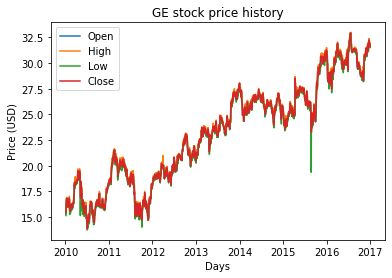

In [5]:
def stock_price_history(symbol):
    symbol_data = df[df.symbol==symbol]
    plt.figure()
    plt.plot(symbol_data["open"],label="Open")
    plt.plot(symbol_data["high"],label="High")
    plt.plot(symbol_data["low"],label="Low")
    plt.plot(symbol_data["close"],label="Close")
    plt.title("{} stock price history".format(symbol))
    plt.ylabel('Price (USD)')
    plt.xlabel('Days')
    plt.legend(loc='upper left')
    plt.show()

stock_price_history(SAMPLE_SYMBOL)

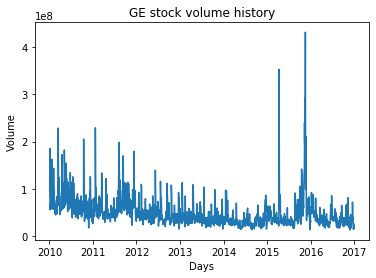

In [6]:
def stock_volume_history(symbol):
    symbol_data = df[df.symbol==symbol]
    plt.figure()
    plt.plot(symbol_data["volume"])
    plt.title("{} stock volume history".format(symbol))
    plt.ylabel('Volume')
    plt.xlabel('Days')
    plt.show()

stock_volume_history(SAMPLE_SYMBOL)

In [7]:
def check_null(symbol):
    symbol_data = df[df.symbol == symbol]
    return symbol_data.isna().sum()
check_null(SAMPLE_SYMBOL)

symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [8]:
symbol_df = df[df.symbol == SAMPLE_SYMBOL]

In [87]:
iter_changes = "dropout_layers_0.4_0.4"
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 50,
    "lr": 0.00010000,
    "time_steps": 90
}
INPUT_PATH = "./inputs"
OUTPUT_PATH = "./outputs/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [88]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["open","high","low","close","volume"]
df_train, df_test = train_test_split(symbol_df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 1409 353


In [89]:
from tqdm import tqdm_notebook
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - params["time_steps"]
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, params["time_steps"], dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:params["time_steps"]+i]
        y[i] = mat[params["time_steps"]+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [90]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [91]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, params["batch_size"])
y_t = trim_dataset(y_t, params["batch_size"])
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, params["batch_size"]),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, params["batch_size"]),2)


length of time-series i/o (1319, 90, 5) (1319,)



length of time-series i/o (263, 90, 5) (263,)


In [92]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers
from keras.callbacks import CSVLogger

In [93]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(params["batch_size"], params["time_steps"], x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=params["lr"])
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [94]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)
history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=params["batch_size"],
                    shuffle=False, validation_data=(trim_dataset(x_val, params["batch_size"]),
                    trim_dataset(y_val, params["batch_size"])),callbacks=[csv_logger])

Train on 1300 samples, validate on 120 samples
Epoch 1/50
 - 2s - loss: 0.0750 - val_loss: 0.3232
Epoch 2/50
 - 2s - loss: 0.0575 - val_loss: 0.1651
Epoch 3/50
 - 2s - loss: 0.0433 - val_loss: 0.0618
Epoch 4/50
 - 2s - loss: 0.0423 - val_loss: 0.0518
Epoch 5/50
 - 2s - loss: 0.0371 - val_loss: 0.0493
Epoch 6/50
 - 2s - loss: 0.0319 - val_loss: 0.0494
Epoch 7/50
 - 2s - loss: 0.0274 - val_loss: 0.0492
Epoch 8/50
 - 2s - loss: 0.0241 - val_loss: 0.0492
Epoch 9/50
 - 2s - loss: 0.0214 - val_loss: 0.0490
Epoch 10/50
 - 2s - loss: 0.0185 - val_loss: 0.0484
Epoch 11/50
 - 2s - loss: 0.0159 - val_loss: 0.0482
Epoch 12/50
 - 2s - loss: 0.0138 - val_loss: 0.0465
Epoch 13/50
 - 2s - loss: 0.0126 - val_loss: 0.0459
Epoch 14/50
 - 2s - loss: 0.0103 - val_loss: 0.0445
Epoch 15/50
 - 2s - loss: 0.0100 - val_loss: 0.0430
Epoch 16/50
 - 2s - loss: 0.0091 - val_loss: 0.0435
Epoch 17/50
 - 2s - loss: 0.0087 - val_loss: 0.0427
Epoch 18/50
 - 2s - loss: 0.0082 - val_loss: 0.0419
Epoch 19/50
 - 2s - loss: 

In [95]:
from sklearn.metrics import mean_squared_error
import os
import time

In [96]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

Error is 0.05141188362698374 (120,) (120,)
[0.92555386 0.9263625  0.9263943  0.92580605 0.925513   0.92566544
 0.9262318  0.92706406 0.92782617 0.9287297  0.9298699  0.9311327
 0.93248093 0.9337722  0.9350288 ]
[1.1831853  1.08954204 1.05536569 1.09774443 1.13943944 1.20300752
 1.20369105 1.20095701 1.22077922 1.22624744 1.25222153 1.25290492
 1.25632249 1.26315796 1.28161319]
[27.420853 27.432684 27.433147 27.424541 27.420256 27.422485 27.43077
 27.442947 27.454098 27.467316 27.483997 27.502472 27.522196 27.541088
 27.559471]
[31.190001 29.82     29.32     29.940001 30.549999 31.48     31.49
 31.450001 31.74     31.82     32.200001 32.209999 32.259998 32.360001
 32.630001]
Error is 0.05141160409201584 (120,) (120,)
[0.92556274 0.9263709  0.9264024  0.925814   0.9255205  0.92567235
 0.92623806 0.92706984 0.9278313  0.9287342  0.9298736  0.9311354
 0.9324827  0.9337731  0.93502915]
[1.1831853  1.08954204 1.05536569 1.09774443 1.13943944 1.20300752
 1.20369105 1.20095701 1.22077922 1.226

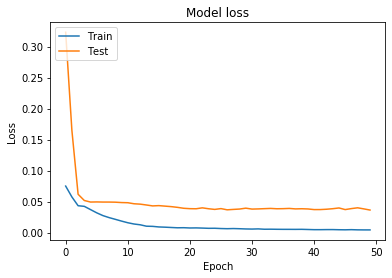

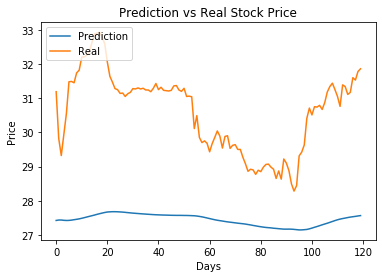

In [97]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
# saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
saved_model = lstm_model
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)